# Лабораторная работа 8

## Динамические сети

### Тимофеев А. В., М8О-407Б-19

Целью работы является исследование свойств некоторых динамических нейронных сетей,
алгоритмов обучения, а также применение сетей в задачах аппроксимации функций и распознавания динамических образов.

Вариант 12

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from collections import deque

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Обучение на " + device)

Обучение на cuda


# NARX

In [44]:
class TDL(nn.Module):
    def __init__(self, in_features, delays):
        super(TDL, self).__init__()
        self.in_features = in_features
        self.delays = delays
        self.line = deque()
        self.clear()
        
    def clear(self):
        self.line.clear()
        for _ in range(self.delays):
            self.line.append(torch.zeros(1, self.in_features))
    
    def push(self, x):
        self.line.appendleft(x)
    
    def forward(self):
        return self.line.pop()

In [45]:
class NARX(nn.Module):
    def __init__(self, in_features, hid_features, out_features, in_delay, out_delay):
        super(NARX, self).__init__()        
        self.in_tdl = TDL(in_features, in_delay)
        self.out_tdl = TDL(out_features, out_delay)
        
        self.w1 = nn.Parameter(torch.randn(in_features, hid_features))
        self.b1 = nn.Parameter(torch.zeros(hid_features))
        
        self.w2 = nn.Parameter(torch.randn(out_features, hid_features))
        
        self.w3 = nn.Parameter(torch.randn(hid_features, out_features))
        self.b3 = nn.Parameter(torch.zeros(out_features))
        
    def clear(self):
        self.in_tdl.clear()
        self.out_tdl.clear()
        
    def forward(self, x):
        out = torch.tanh(self.in_tdl() @ self.w1 + self.b1 + self.out_tdl() @ self.w2)
        out = out @ self.w3 + self.b3
        
        self.in_tdl.push(x.detach().clone())
        self.out_tdl.push(out.detach().clone())
        return out

## Данные

In [46]:
f = lambda k: np.sin(-2 * k ** 2 + 7 * k) - 0.5 * np.sin(k)
h = 0.01
k = np.arange(0, 10+h, h)

u = f(k)
y = [0]
for i in range(0, len(k)-1):
    y.append(y[-1] / (1 + y[-1] ** 2) + u[i] ** 3)

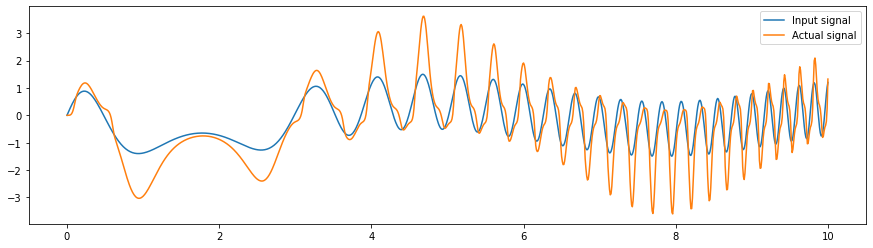

In [47]:
fig = plt.figure(figsize=(15, 4))
plt.plot(k, u, label='Input signal')
plt.plot(k, y, label='Actual signal')
plt.legend()
plt.show()

## Обучение и тестирование сети

In [48]:
def fit(model, optim, crit, epochs, data):
    model.train()
    train_loss = []
    pbar = tqdm.trange(epochs, ascii=True)
    for i in pbar:
        model.clear()
        avg_loss = 0
        for X_batch, Y_batch in data:        
            optim.zero_grad()
            
            output = model(X_batch)
            loss = crit(Y_batch, output)
            loss.backward()
            
            optim.step()
            avg_loss += loss.item() / len(data)
        train_loss.append(avg_loss)
        pbar.set_description(f'Epoch: {i+1}. Loss: {avg_loss:.8f}')
    return train_loss
        
def predict(model, data, window):
    model.eval()
    model.clear()
    with torch.no_grad():
        pred = [*model(next(iter(data))[0]).detach().numpy()[0, :window-1]]
        model.clear()
        for X, _ in data:
            pred.append(model(X).detach().numpy().item(-1))
    return pred

In [49]:
def plot_loss(history):
    print("Loss: ", history[-1])
    fig = plt.figure(figsize=(6, 3))
    ax = fig.gca()
    ax.xaxis.get_major_locator().set_params(integer=True)
    ax.set_title(f'Loss')
    ax.plot(history, '-')
    plt.show()
    
def plot_result(model, data, window, k, y):
    pred = predict(model, data, window)
    fig = plt.figure(figsize=(20, 4))
    plt.plot(k, u, label='Input signal')
    plt.plot(k, y, label='Actual signal')
    plt.plot(k, pred, label='Predicted signal')
    plt.legend()
    plt.show()

In [50]:
window = 5
train_data = [(np.array(u[i:i + window], dtype=np.float32), np.array(y[i:i + window], dtype=np.float32)) for i in range(len(k) - window + 1)]
train_loader = DataLoader(train_data, batch_size=1, shuffle=False)

In [51]:
model = NARX(window, 15, window, 3, 3)
hist = fit(model, torch.optim.Adam(model.parameters(), lr=1e-4), nn.MSELoss(), 200, train_loader)

Epoch: 200. Loss: 0.14947220: 100%|##########| 200/200 [02:19<00:00,  1.44it/s]


Loss:  0.14947219683280552


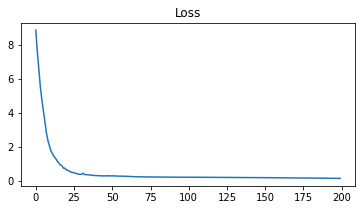

In [52]:
plot_loss(hist)

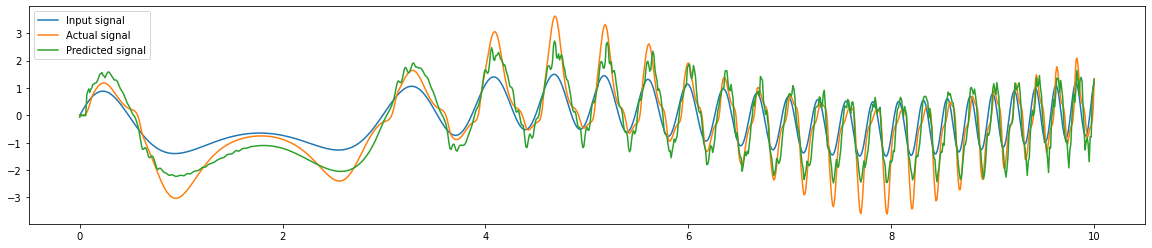

In [53]:
plot_result(model, train_loader, window, k, y)

In [54]:
window = 3
train_data = [(np.array(u[i:i + window], dtype=np.float32), np.array(y[i:i + window], dtype=np.float32)) for i in range(len(k) - window + 1)]
train_loader = DataLoader(train_data, batch_size=1, shuffle=False)

In [55]:
model = NARX(window, 20, window, 2, 2)
hist = fit(model, torch.optim.Adam(model.parameters(), lr=1e-3), nn.MSELoss(), 100, train_loader)

Epoch: 100. Loss: 0.04018600: 100%|##########| 100/100 [01:09<00:00,  1.43it/s]


Loss:  0.04018600233992631


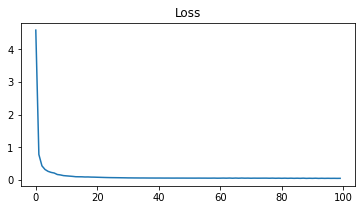

In [56]:
plot_loss(hist)

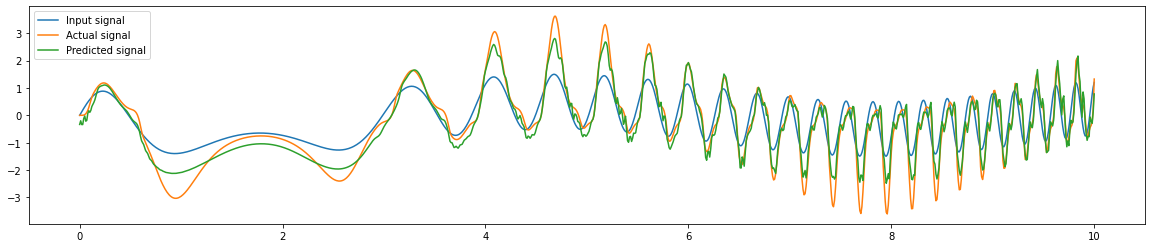

In [57]:
plot_result(model, train_loader, window, k, y)

In [58]:
window = 2
train_data = [(np.array(u[i:i + window], dtype=np.float32), np.array(y[i:i + window], dtype=np.float32)) for i in range(len(k) - window + 1)]
train_loader = DataLoader(train_data, batch_size=1, shuffle=False)

In [59]:
model = NARX(window, 20, window, 2, 2)
hist = fit(model, torch.optim.Adam(model.parameters(), lr=1e-3), nn.MSELoss(), 100, train_loader)

Epoch: 100. Loss: 0.03679636: 100%|##########| 100/100 [01:10<00:00,  1.42it/s]


Loss:  0.036796360677426046


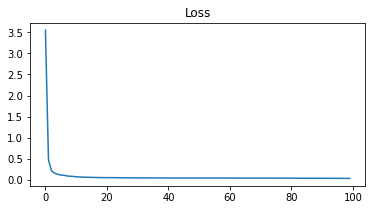

In [60]:
plot_loss(hist)

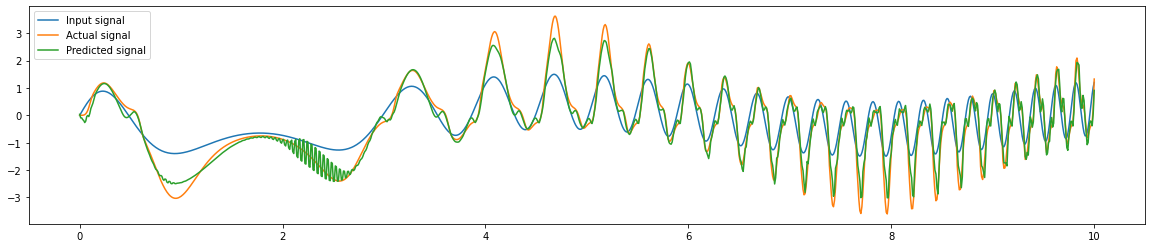

In [61]:
plot_result(model, train_loader, window, k, y)

### Вывод

Выполнив восьмую лабораторную работу я изучил динамическую нейронную сеть NARX, а также ее алгоритм обучения и применил ее для задачи аппроксимации функций и распознавания динамических образов.
